In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)

from dis2p.dis2pvi import Dis2pVI
# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


# prepare data: Heart Atlas

Define function to convert covariate names to numerical values

In [2]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

Load and subsample the heart atlas dataset from Litvinukova et al. Nature 2020

In [3]:
adata = scvi.data.heart_cell_atlas_subsampled()

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


# train model: dis2p(n_cf=1)

In [4]:
# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:

    Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = Dis2pVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     No backup URL provided for missing file                                                                   
         models/dis2p/2024-03-08,dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_w
         eight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt                                                   


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 96/400:  24%|▏| 95/400 [38:46<2:42:05, 31.89s/it, v_num=1, loss_validation=2.16e+3, x_0_validation=293, x_1_validation=297, x_2_validation=298, Epoch 00096: reducing learning rate of group 0 to 6.0000e-04.
Epoch 110/400:  28%|▎| 110/400 [44:25<1:57:07, 24.23s/it, v_num=1, loss_validation=2.16e+3, x_0_validation=293, x_1_validation=297, x_2_validation=298
Monitored metric loss_validation did not improve in the last 45 records. Best score: 2151.481. Signaling Trainer to stop.


# get latent space

In [5]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

INFO     File                                                                                                      
         models/dis2p/2024-03-08,dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_w
         eight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                


# plot UMAP latent

In [6]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

---UMAP for dis2p_Z_0---


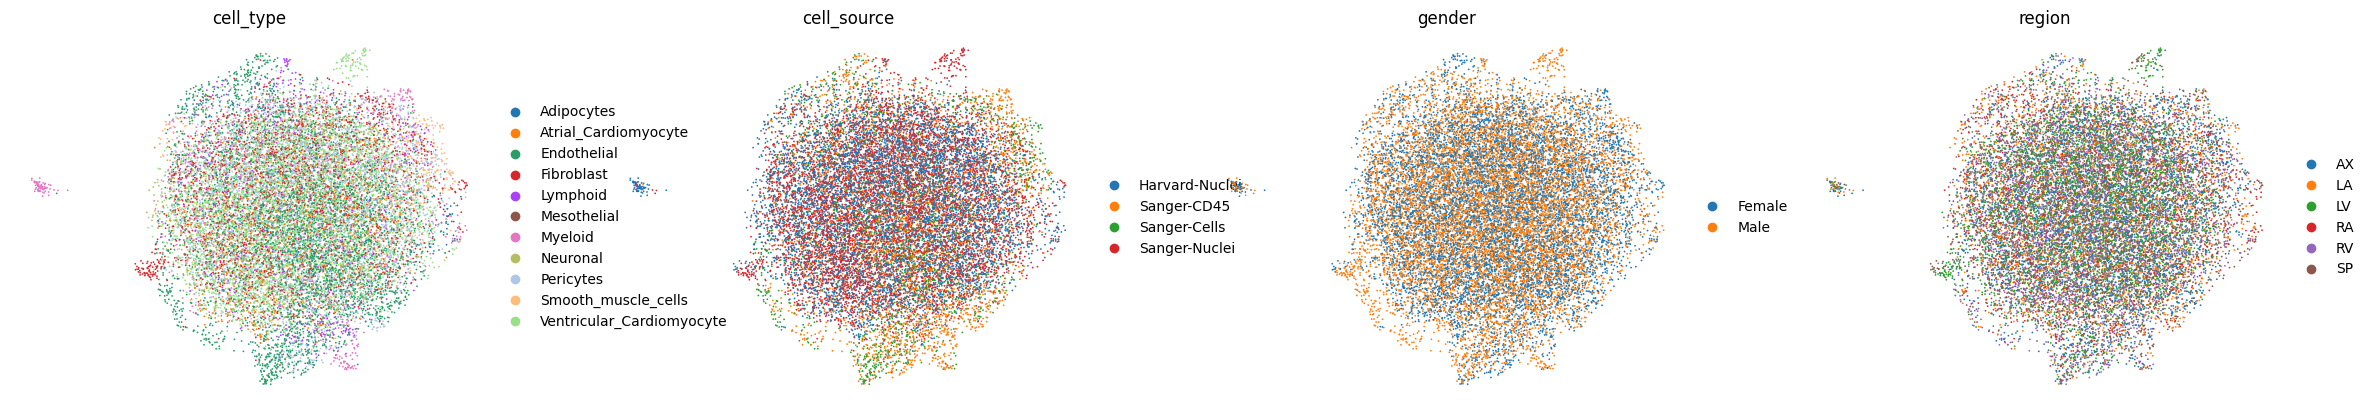

---UMAP for dis2p_Z_1---


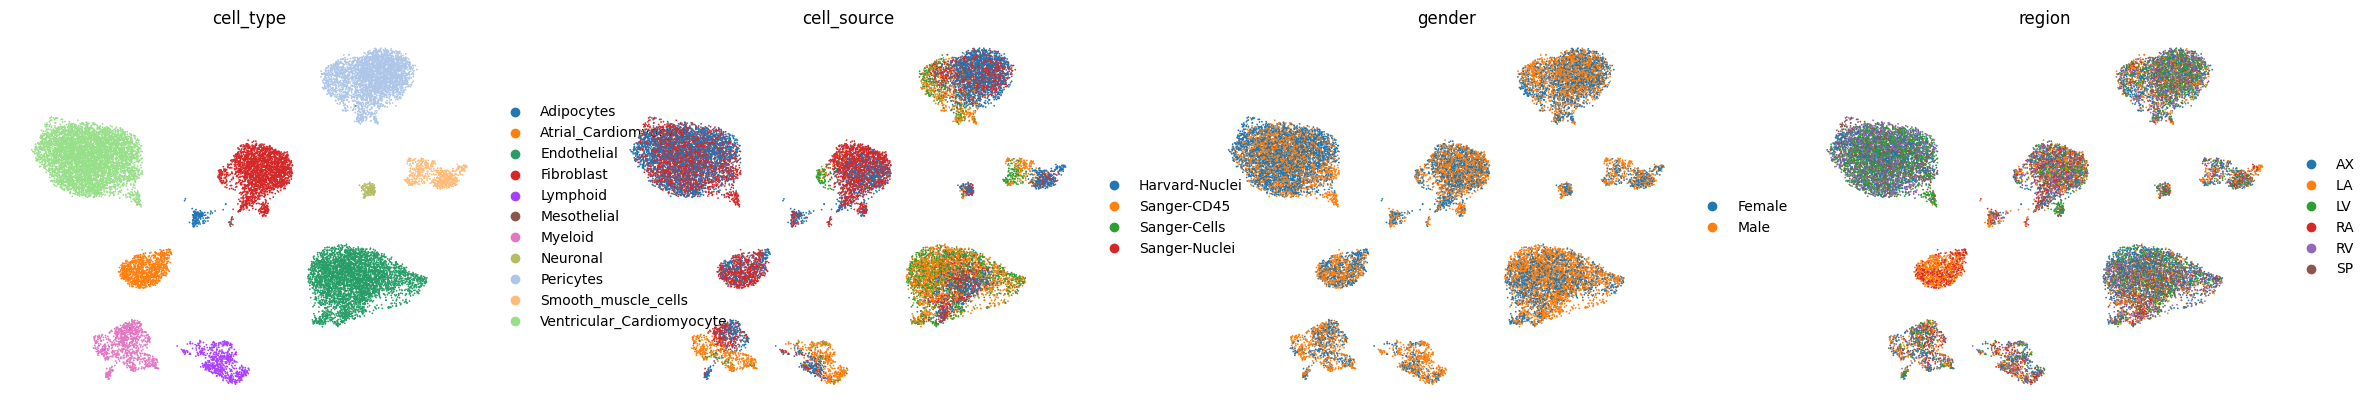

---UMAP for dis2p_Z_2---


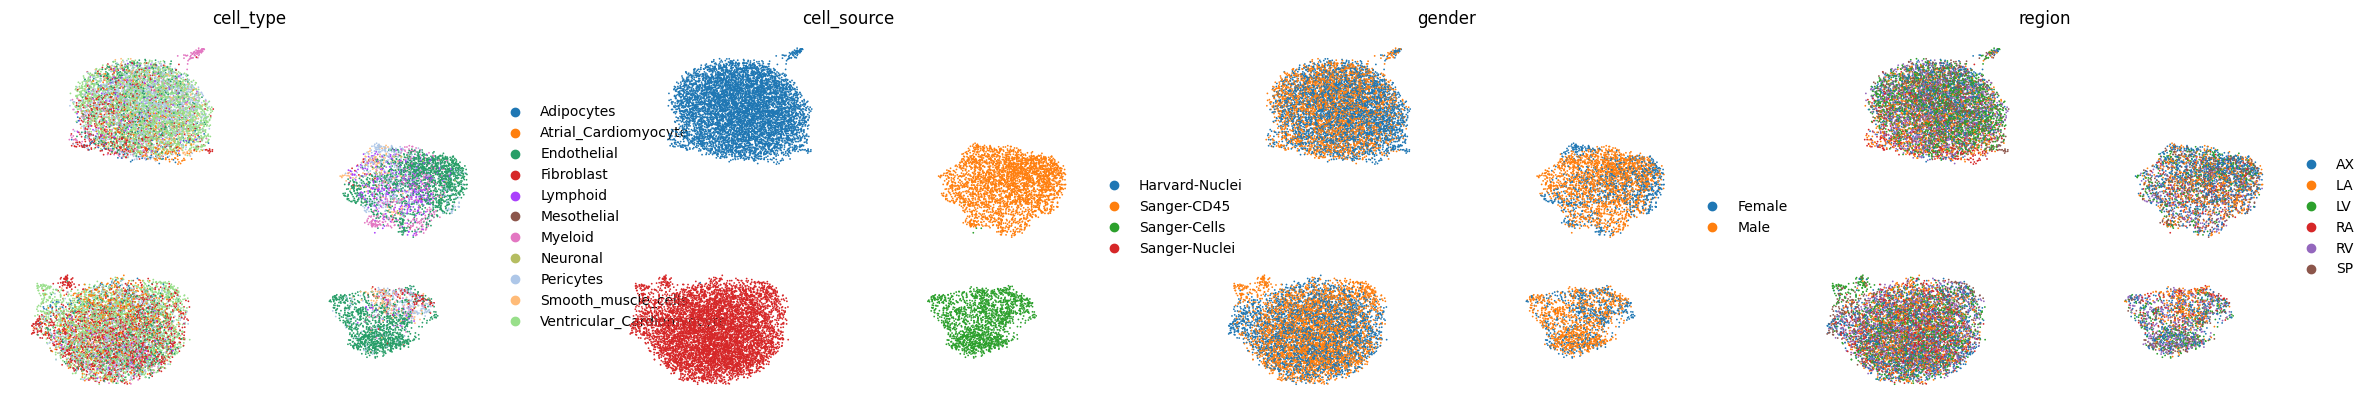

---UMAP for dis2p_Z_3---


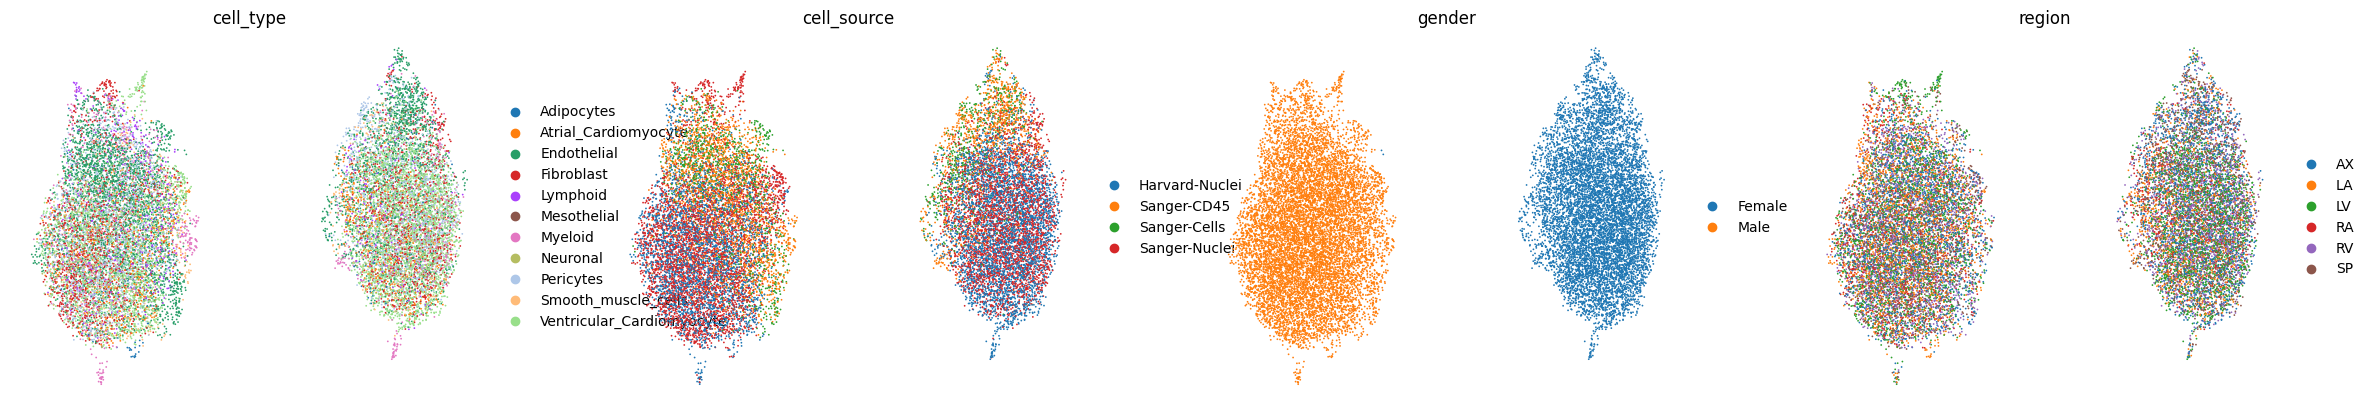

---UMAP for dis2p_Z_4---


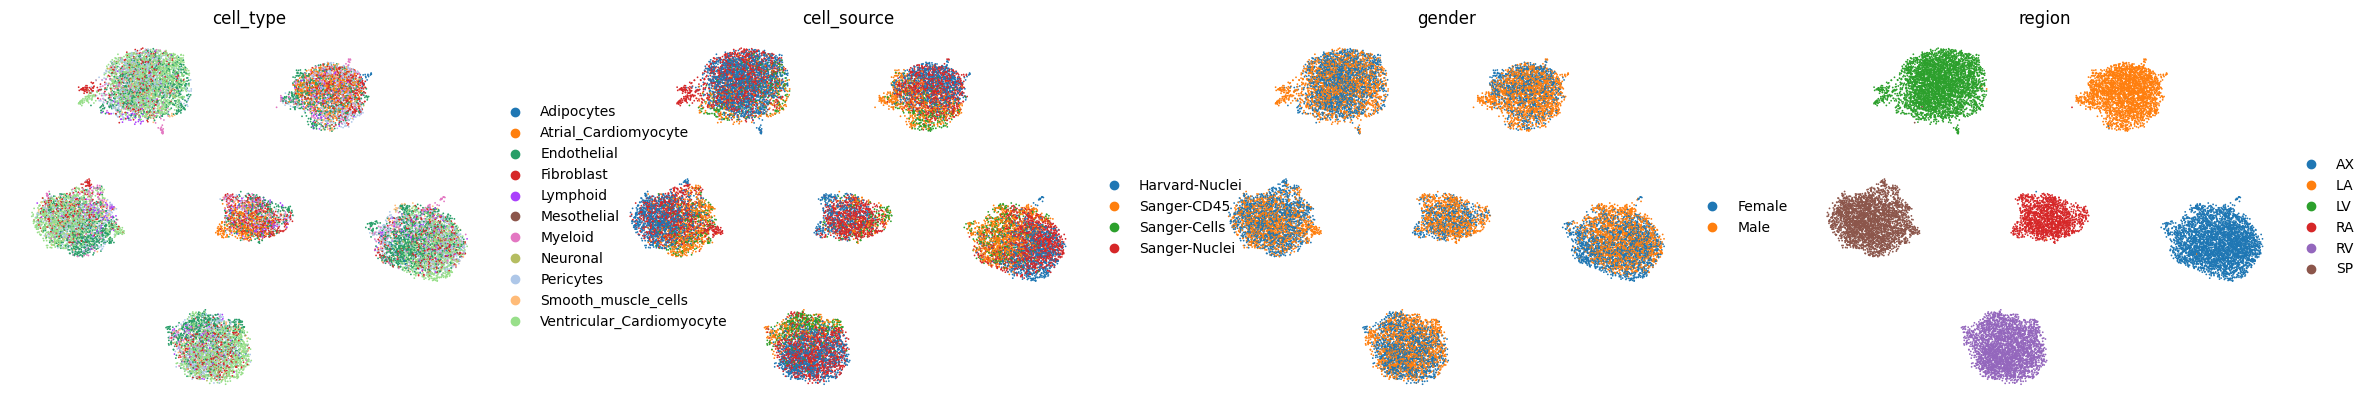

In [7]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

# Perform MIG benchmarking

In [8]:
from dis2pm_dev.scfair_reproducibility.benchmark_VAE.vi import VI
from dis2pm_dev.scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from dis2pm_dev.scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker


In [9]:
MI, MI_not_max, MI_not, MI_dif_max, MI_dif, maxMIG, concatMIG = Mixed_KSG_MI_metrics(adata, cats, module_name)

# DP, EO
create_cats_idx(adata, ['NRP'])
y_name = 'NRP_idx'
acc, DP_diff, EO_diff = fair_clf_metrics(adata, cats, y_name, module_name)

# classifier Si
acc, acc_not_concat, acc_not_max, acc_gap_concat, acc_gap_max = clf_S_Z_metrics(adata, cats, module_name)


# convert results to dataframes
df_MI = pd.DataFrame(
      [MI, MI_not_max, MI_not, MI_dif_max, MI_dif]
)

df_fairness = pd.DataFrame(
      [acc, DP_diff, EO_diff]
)

df_acc = pd.DataFrame(
      [acc, acc_not_concat, acc_not_max, acc_gap_concat, acc_gap_max]
)

# create output folder and save csv
metrics_dir = f'metrics/{module_name}/'
os.makedirs(metrics_dir, exist_ok=True)  
df_acc.to_csv(metrics_dir+model_name+',acc.csv')
df_fairness.to_csv(metrics_dir+model_name+',fair.csv') 
df_MI.to_csv(metrics_dir+model_name+',MI.csv')


Method: dis2p
Mixed_KSG Mutual Information metrics
MI(Z_1 ; S_1) = 1.7807,  MI((Z - Z_1) ; S_1) = 0.7695, max MI((Z_j!=1) ; S_1) = 0.7293
MI(Z_2 ; S_2) = 1.2474,  MI((Z - Z_2) ; S_2) = 0.1843, max MI((Z_j!=2) ; S_2) = 0.5063
MI(Z_3 ; S_3) = 0.6782,  MI((Z - Z_3) ; S_3) = 0.0899, max MI((Z_j!=3) ; S_3) = 0.1258
MI(Z_4 ; S_4) = 1.7330,  MI((Z - Z_4) ; S_4) = 0.3339, max MI((Z_j!=4) ; S_4) = 0.3448
maxMIG = 0.6845, concatMIG = 0.7578
Method: dis2p
fairness metrics wrt Si for XGBoost classifier NRP_idx_bin | (Z - Zi)
i=1: accuracy = 0.9699, DP_diff = 0.0000, EO_diff = 0.2000
i=2: accuracy = 0.8846, DP_diff = 0.2000, EO_diff = 0.8000
i=3: accuracy = 0.9051, DP_diff = 0.0000, EO_diff = 0.0000
i=4: accuracy = 0.9679, DP_diff = 0.0000, EO_diff = 0.0000
average: accuracy = 0.9319, DP_diff = 0.0500, EO_diff = 0.2500
Method: dis2p
XGBoost classifier for Si
acc(S_1 | Z_1) = 0.9969, acc(S_1 | Z - Z_1) = 0.7317, max acc(S_1 | Z_j!=1) = 0.5367
acc(S_2 | Z_2) = 0.9988, acc(S_2 | Z - Z_2) = 0.7627, max

In [10]:
adata.obs.head()

,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,...,cell_states,Used,cell_type_idx,cell_source_idx,gender_idx,region_idx,_scvi_batch,_scvi_labels,NRP_idx,NRP_idx_bin
AACTCCCCACGAGAGT-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Myeloid,D6,Male,1420.0,738,0.054930,0.064789,...,LYVE1+MØ1,Yes,9,1,0,3,0,0,0,0
ATAACGCAGAGCTGGT-1-HCAHeart7829979,No,70-75,Sanger-Nuclei,Ventricular_Cardiomyocyte,D4,Female,844.0,505,0.001185,0.001185,...,vCM1,Yes,2,0,1,5,0,0,1,1
GTCAAGTCATGCCACG-1-HCAHeart7702879,Yes,60-65,Sanger-Nuclei,Fibroblast,D2,Male,1491.0,862,0.000000,0.005366,...,FB2,Yes,7,0,0,2,0,0,0,0
GGTGATTCAAATGAGT-1-HCAHeart8102858,Yes,60-65,Sanger-CD45,Endothelial,D11,Female,2167.0,1115,0.064144,0.027227,...,EC10_CMC-like,Yes,0,1,1,3,0,0,0,0
AGAGAATTCTTAGCAG-1-HCAHeart8102863,Yes,60-65,Sanger-Cells,Endothelial,D11,Female,7334.0,2505,0.093537,0.040496,...,EC5_art,Yes,0,3,1,2,0,0,0,0
